In [1]:
import numpy as np
from numpy.random import RandomState
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
%matplotlib inline

from Tree import Tree
from GGBM import GGBM
from Losses import MSE
from dataset_transform import get_first_entries, OptEntry

### Simplest regression for the tree, to check, that it works somehow.

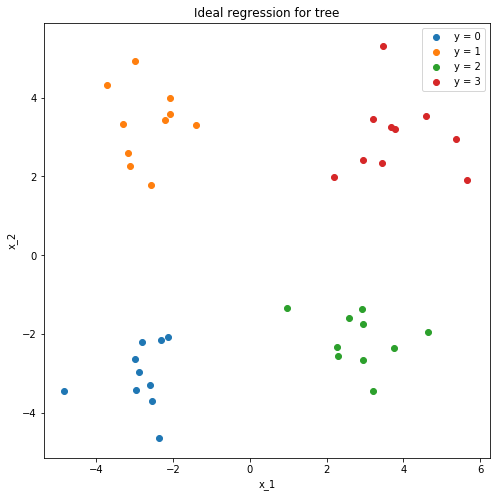

In [2]:
y = 0
size = 10
rs = RandomState(117)

a=3

X_train = np.empty((0, 2))
y_train = np.empty(0)

plt.figure(figsize=(8, 8))
plt.title('Ideal regression for tree')
plt.xlabel('x_1')
plt.ylabel('x_2')

for mean_x in [-a, a]:
    for mean_y in [-a, a]:
        mean = (mean_x, mean_y)
        cov = np.eye(2)
        X_new = rs.multivariate_normal(mean, cov, size=size)
        plt.scatter(X_new[:, 0], X_new[:, 1], label='y = {}'.format(y))
        X_train = np.vstack([X_train, X_new])
        y_train = np.hstack([y_train, np.ones(size) * y])
        y += 1
plt.legend()

Let's see what error our tree got on this dataset, should be close to 0

In [3]:
mse = MSE(len(y_train))
entries, tresholds = get_first_entries(X_train, y_train, 4, mse, y_train.mean())
n_features = len(tresholds)
n_bins = len(tresholds[0]) - 1
tree = Tree(3, mse, entries, n_features, n_bins, 0, 0.01)
tree.construct()

loss = 0
for entry in entries:
    loss += (entry.y - (tree.predict(entry.x) + entry.prediction)) ** 2
print("MSE is {}".format(loss / len(entries)))

MSE is 1.232595164407831e-32


In [4]:
ggb = GGBM(2, mse, 8, 0, 0, 1, 1)
ggb.fit(X_train, y_train)
print("GGBM MSE with one tree depth two is {}".format(((y_train - ggb.predict(X_train))**2).mean()))

GGBM MSE with one tree depth two is 1.232595164407831e-32


In [5]:
ggb = GGBM(1, mse, 8, 0, 0, 1, 2)
ggb.fit(X_train, y_train)
print("GGBM MSE with two trees depth one is {}".format(((y_train - ggb.predict(X_train))**2).mean()))

GGBM MSE with two trees depth one is 9.860761315262648e-32


In [6]:
ggb = GGBM(1, mse, 10, 0, 0, 0.8, 8)
ggb.fit(X_train, y_train)
print("GGBM MSE with eight trees depth one and\
 eps = 0.8 is {}".format(((y_train - ggb.predict(X_train))**2).mean()))

GGBM MSE with eight trees depth one and eps = 0.8 is 3.1999999999995573e-06


### Comparison with sklear decision tree regression

In [7]:
# Create a random dataset
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(16))

# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_1.fit(X, y)
regr_2.fit(X, y)

# Predict
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)

In [8]:
entries, tresholds = get_first_entries(X, y, 6, mse, y.mean())
mse = MSE(len(y))
n_features = len(tresholds)
n_bins = len(tresholds[0]) - 1
tree = Tree(5, mse, entries,  n_features, n_bins, 0.01, 0.01)
tree.construct()

test_predictions = []
for x in X_test:
    x = x[0]
    for i in range(len(tresholds[0]) - 1):
        if x < tresholds[0][0]:
            bin_num = 0
        if x > tresholds[0][-1]:
            bin_num = len(tresholds[0]) - 1
        if x > tresholds[0][i] and x <= tresholds[0][i + 1]:
            bin_num = i
    entry = OptEntry([bin_num], np.sin(x), 0, 0, entries[0].prediction)
    test_predictions.append(tree.predict(entry.x) + entry.prediction)
    


In [9]:
mse = MSE(len(y))
ggb = GGBM(3, mse, 32, 0.01, 0.001, 0.5, 100)
ggb.fit(X, y)

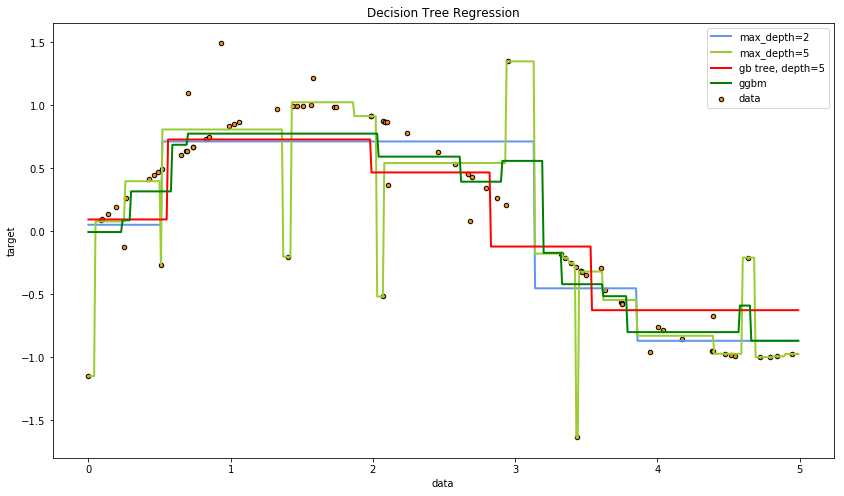

In [10]:
# Plot the results
plt.figure(figsize=(14, 8))
plt.scatter(X, y, s=20, edgecolor="black",
            c="darkorange", label="data")
plt.plot(X_test, y_1, color="cornflowerblue",
         label="max_depth=2", linewidth=2)
plt.plot(X_test, y_2, color="yellowgreen", label="max_depth=5", linewidth=2)
plt.plot(X_test, test_predictions, color="red", label="gb tree, depth=5", linewidth=2)
plt.plot(X_test, ggb.predict(X_test), color="green", label="ggbm", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

In [16]:
for i in y:
    print(str(i) + ',', end='')

-1.14934639956,0.0913140083794,0.0966835240333,0.136510390143,0.194035252505,-0.123838139635,0.263658284747,0.412522163019,0.445464463469,0.472155294175,-0.263191383754,0.493517993748,0.605300128562,0.634509327341,0.641446075528,1.09900118952,0.669579780996,0.66968121787,0.735748344309,0.750720533999,1.49261340292,0.836304301109,0.853289302978,0.871444956283,0.970605329114,-0.201834032854,0.991311216828,0.994728365312,0.998252126154,0.999993245593,1.21570343388,0.987699652019,0.985915646413,0.915904395296,0.914069859049,-0.516690127122,0.877534604956,0.870630545596,0.869934081667,0.865235591787,0.370075749,0.78464607529,0.631686552992,0.537227991006,0.458019714487,0.0807511860166,0.432721158392,0.341153282781,0.267699531349,0.207303184956,1.34959235345,-0.176451854961,-0.209188374534,-0.249907779228,-0.28068223884,-1.63529378606,-0.312470754007,-0.314585948453,-0.324429114434,-0.349651545066,-0.293711221778,-0.469211145768,-0.564011437069,-0.572153264786,-0.57488849184,-0.955863614657,